In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\nives\AllFolders\SML\mlfs-book
HopsworksSettings initialized!


### Imports

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

### Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-14 23:45:44,036 INFO: Initializing external client
2025-11-14 23:45:44,037 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-14 23:45:45,525 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279175


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [ ]:
# Feature view for lagged pm25
#pm25_with_lags = air_quality_fg.select(['pm25', 'date']) \
#    .join(air_quality_fg.select(['pm25']), left_on='date', right_on='date_lagged_1')

In [5]:
# Select features for training data
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

selected_features_lagged_1 = air_quality_fg.select(['pm25_lagged_1', 'pm25', 'date']).join(weather_fg.select_features(), on=['city'])
selected_features_lagged_2 = air_quality_fg.select(['pm25_lagged_1', 'pm25_lagged_2', 'pm25', 'date']).join(weather_fg.select_features(), on=['city'])
selected_features_lagged_3 = air_quality_fg.select(['pm25_lagged_1', 'pm25_lagged_2', 'pm25_lagged_3', 'pm25', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-14 23:49:36,690 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
2025-11-14 23:49:36,691 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
2025-11-14 23:49:36,691 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
2025-11-14 23:49:36,691 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

In [6]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

feature_view_lagged_1 = fs.get_or_create_feature_view(
    name='air_quality_fv_lagged_1',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features_lagged_1,
)
feature_view_lagged_2 = fs.get_or_create_feature_view(
    name='air_quality_fv_lagged_2',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features_lagged_2,
)
feature_view_lagged_3 = fs.get_or_create_feature_view(
    name='air_quality_fv_lagged_3',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features_lagged_3,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279175/fs/1265791/fv/air_quality_fv_lagged_1/version/1
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279175/fs/1265791/fv/air_quality_fv_lagged_2/version/1
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279175/fs/1265791/fv/air_quality_fv_lagged_3/version/1


In [7]:
# Check Feature view
feature_view = fs.get_feature_view(name="air_quality_fv", version=1)
feature_view.schema

[Training Dataset Feature('pm25', 'float', 0, True, pm25, 1703314, None),
 Training Dataset Feature('date', 'timestamp', 1, False, date, 1703314, None),
 Training Dataset Feature('temperature_2m_mean', 'float', 2, False, temperature_2m_mean, 1703315, None),
 Training Dataset Feature('precipitation_sum', 'float', 3, False, precipitation_sum, 1703315, None),
 Training Dataset Feature('wind_speed_10m_max', 'float', 4, False, wind_speed_10m_max, 1703315, None),
 Training Dataset Feature('wind_direction_10m_dominant', 'float', 5, False, wind_direction_10m_dominant, 1703315, None)]

### Split the training data into train/test data sets </span>

In [8]:
start_date_test_data = "2025-06-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.37s) 


In [10]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2022-09-02 00:00:00+00:00,9.880751,1.4,14.799459,356.871185
1,2022-09-03 00:00:00+00:00,9.489084,0.8,6.409617,330.255249
2,2022-09-04 00:00:00+00:00,11.087001,0.2,9.726665,40.922153
3,2022-09-05 00:00:00+00:00,10.680751,0.0,12.181625,339.010712
4,2022-09-06 00:00:00+00:00,12.984916,0.0,15.683776,275.650299
...,...,...,...,...,...
968,2025-05-27 00:00:00+00:00,12.593249,3.8,22.725668,200.998276
969,2025-05-28 00:00:00+00:00,12.857834,0.8,12.669238,200.772339
970,2025-05-29 00:00:00+00:00,14.643252,0.0,12.346741,275.411743
971,2025-05-30 00:00:00+00:00,13.501582,0.5,21.359411,231.688828


In [11]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [12]:
y_train

,pm25
0,7.0
1,8.0
2,7.0
3,14.0
4,12.0
...,...
968,18.0
969,16.0
970,14.0
971,12.0


### Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [13]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 95.96043
R squared: -0.0599613119036706


In [15]:
df = y_test
df['predicted_pm25'] = y_pred

In [16]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
973,14.0,22.797585,2025-06-01 00:00:00+00:00
974,18.0,9.804072,2025-06-02 00:00:00+00:00
975,18.0,26.493608,2025-06-03 00:00:00+00:00
976,32.0,26.107155,2025-06-04 00:00:00+00:00
977,27.0,12.676108,2025-06-05 00:00:00+00:00


In [17]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

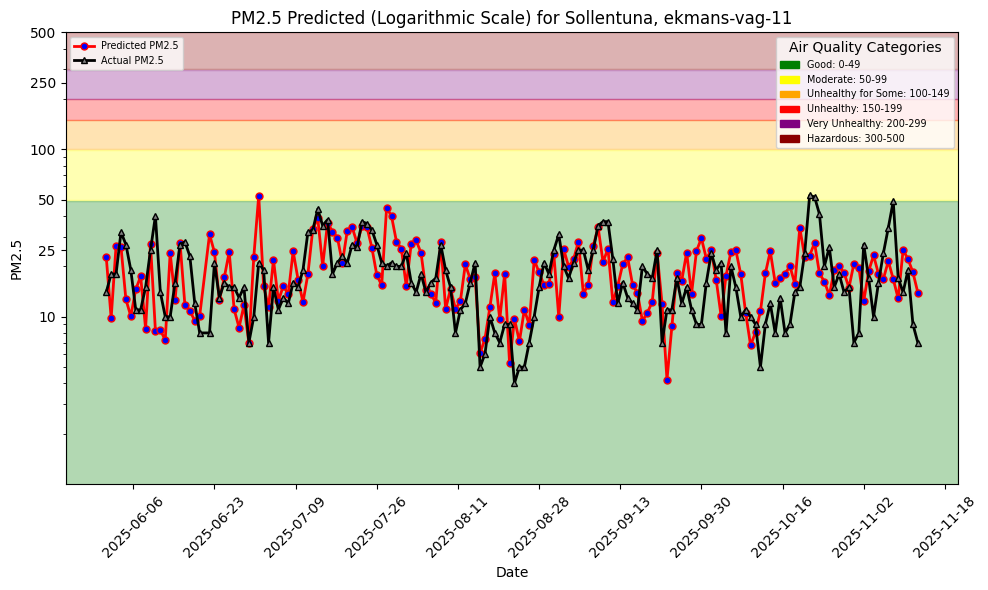

In [18]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

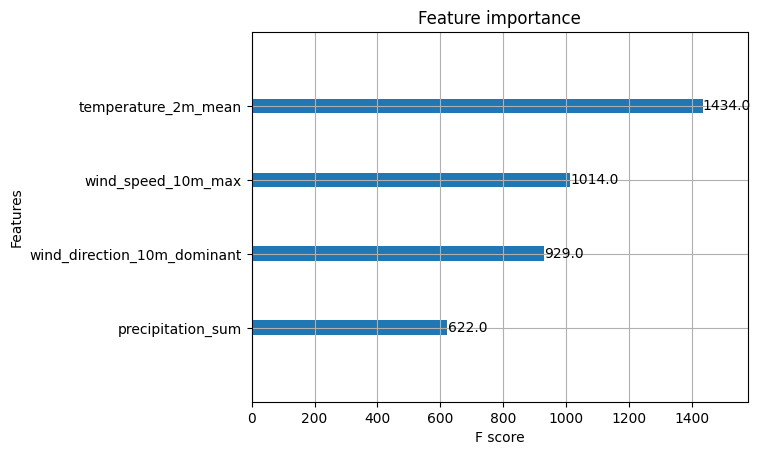

In [19]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

### Model Registry

In [20]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [21]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [22]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model/model.json: 0.000%|  …

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model\images/feature_import…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model\images/pm25_hindcast.…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279175/models/air_quality_xgboost_model/5


Model(name: 'air_quality_xgboost_model', version: 5)

### Do the same for the lagged models

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.11s) 
MSE: 54.113552
R squared: 0.4035856746839106


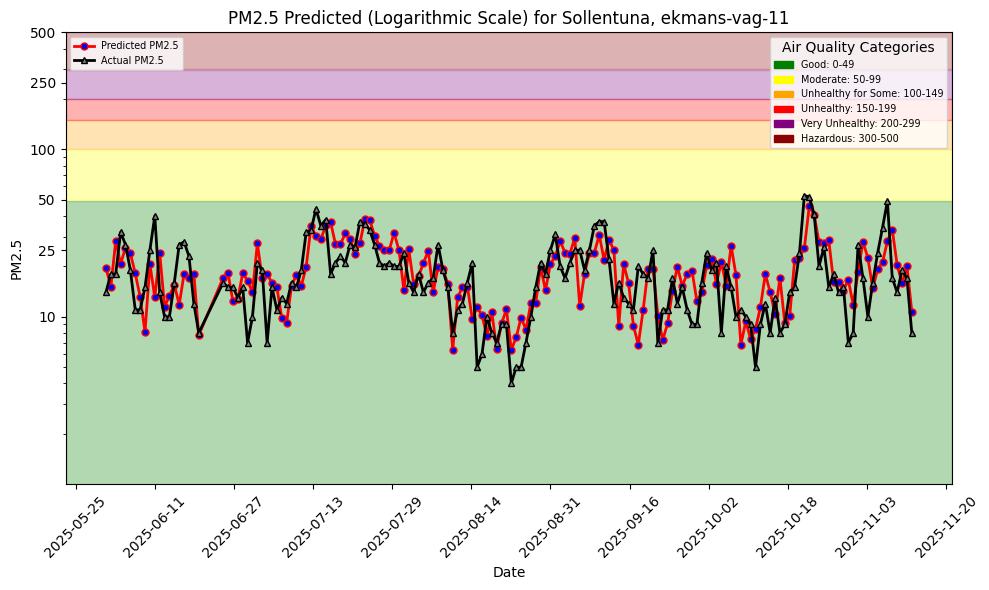

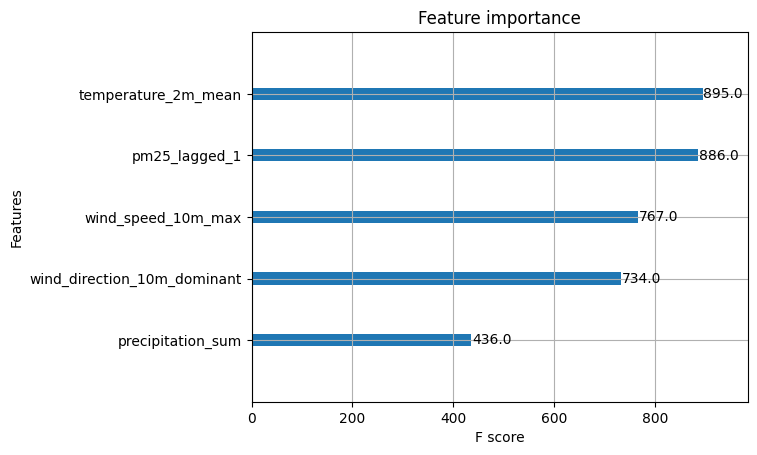

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_1/model.json: …

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_1\images/featu…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_1\images/pm25_…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279175/models/air_quality_xgboost_model_lagged_1/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 
MSE: 58.50331
R squared: 0.35520381725326866


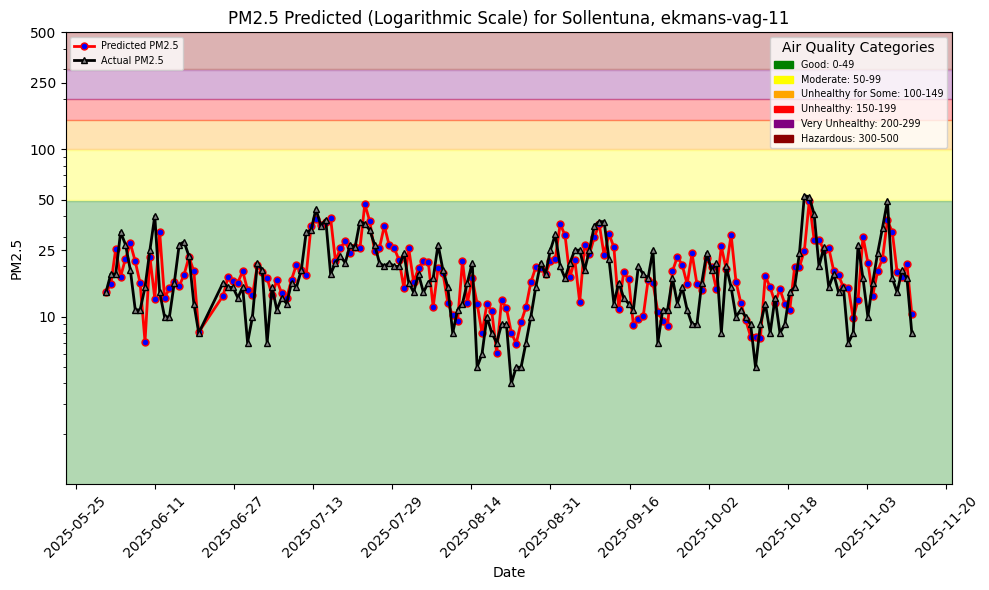

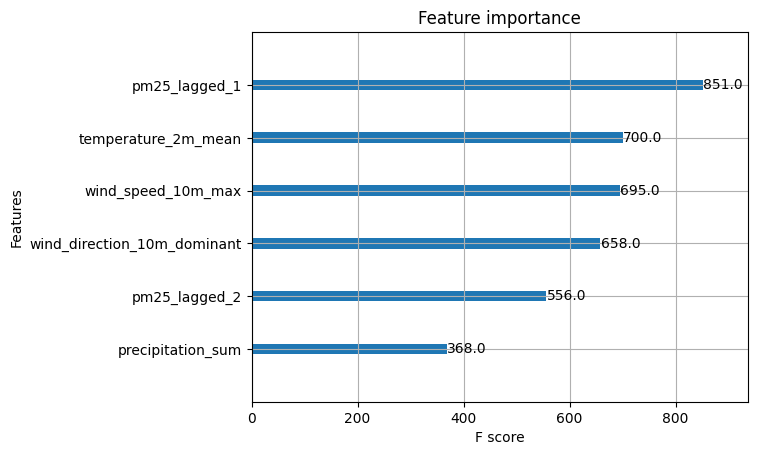

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_2/model.json: …

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_2\images/featu…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_2\images/pm25_…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279175/models/air_quality_xgboost_model_lagged_2/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 
MSE: 50.5473
R squared: 0.4428913464932578


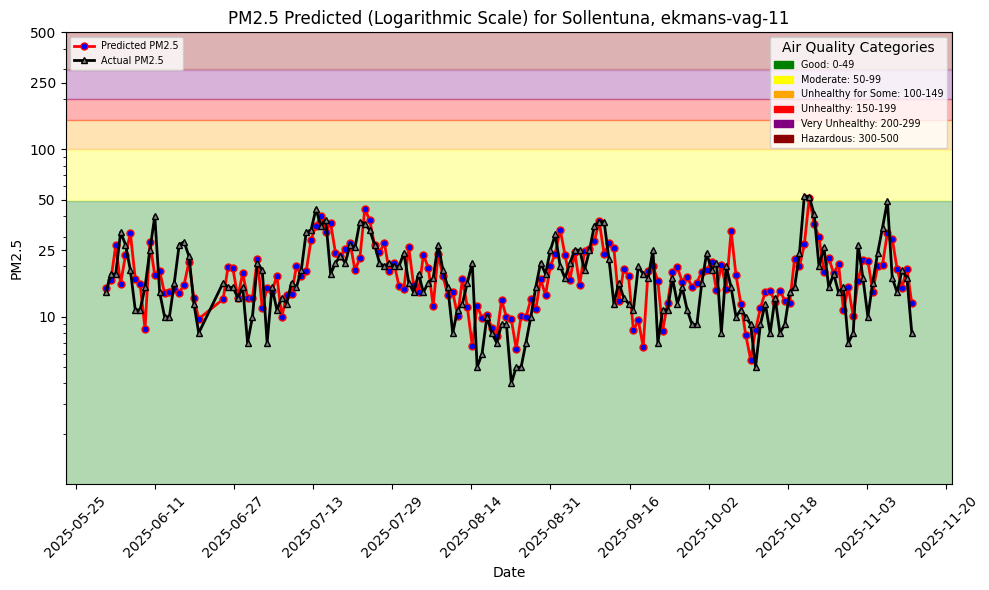

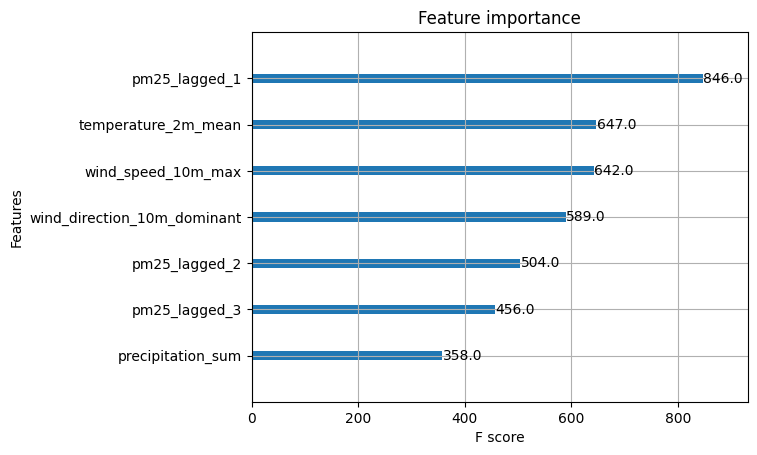

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_3/model.json: …

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_3\images/featu…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\air_quality_model_lagged_3\images/pm25_…

Uploading c:\Users\nives\AllFolders\SML\mlfs-book\notebooks\airquality\model_schema.json: 0.000%|          | 0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279175/models/air_quality_xgboost_model_lagged_3/1


In [24]:
for fv, label in zip([feature_view_lagged_1, feature_view_lagged_2, feature_view_lagged_3], ['_lagged_1', '_lagged_2', '_lagged_3']):
    X_train, X_test, y_train, y_test = fv.train_test_split(
        test_start=test_start
    )
    X_features = X_train.drop(columns=['date'])
    X_test_features = X_test.drop(columns=['date'])

    # Creating an instance of the XGBoost Regressor
    xgb_regressor = XGBRegressor()
    # Fitting the XGBoost Regressor to the training data
    xgb_regressor.fit(X_features, y_train)
    # Predicting target values on the test set
    y_pred = xgb_regressor.predict(X_test_features)

    # Calculating Mean Squared Error (MSE) using sklearn
    mse = mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    # Calculating R squared using sklearn
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    df = y_test
    df['predicted_pm25'] = y_pred
    df['date'] = X_test['date']
    df = df.sort_values(by=['date'])
    df.head(5)

    # Creating a directory for the model artifacts if it doesn't exist
    model_dir = "air_quality_model" + label
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    images_dir = model_dir + "/images"
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)

    file_path = images_dir + "/pm25_hindcast.png"
    plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
    plt.show()

    # Plotting feature importances using the plot_importance function from XGBoost
    plot_importance(xgb_regressor)
    feature_importance_path = images_dir + "/feature_importance.png"
    plt.savefig(feature_importance_path)
    plt.show()

    # Saving the XGBoost regressor object as a json file in the model directory
    xgb_regressor.save_model(model_dir + "/model.json")

    res_dict = { 
            "MSE": str(mse),
            "R squared": str(r2),
        }

    mr = project.get_model_registry()

    # Creating a Python model in the model registry named 'air_quality_xgboost_model'

    aq_model = mr.python.create_model(
        name="air_quality_xgboost_model"+label, 
        metrics= res_dict,
        feature_view=fv,
        description="Air Quality (PM2.5) predictor",
    )

    # Saving the model artifacts to the 'air_quality_model' directory in the model registry
    aq_model.save(model_dir)